# Assignment 5

### Integrantes
- GARCIA RODRIGUEZ, EMILIO ALONSO
- RIEGA NUÑEZ, GABRIEL ANTONIO FERMIN
- SALAMANCA FERNANDEZ, LUCAS PABLO
- SILVA ANDUJAR, NICOLAS

In [ ]:
#!pip install multiprocess


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#!git clone https://github.com/maxhuppertz/hdmpy.git

Cloning into 'hdmpy'...


In [ ]:
#!pip install scikit-learn numpy scipy statsmodels pandas


In [13]:
!pip install econml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV, LinearRegression, Ridge, Lasso, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, clone
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings
from econml.dml import CausalForestDML
from ISLP import load_data
from ISLP.models import ModelSpec as MS
import hdmpy
warnings.simplefilter('ignore')

  Using cached econml-0.15.1-cp312-cp312-win_amd64.whl.metadata (39 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached sparse-0.15.4-py2.py3-none-any.whl.metadata (4.5 kB)
  Using cached shap-0.43.0.tar.gz (389 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached lightgbm-4.5.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached slicer-0.0.7-py3-none-any.whl.metadata (3.7 kB)
Using cached econml-0.15.1-cp312-cp312-win_amd64.whl (2.0 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
Using cached lightgbm-4.5.0-py3-none-win_amd64.whl (1.4 MB)
Using cached sparse-0.15.4-py2.py3-none-any.whl 

  error: subprocess-exited-with-error
  
  × Building wheel for shap (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [169 lines of output]
      The nvcc binary could not be located in your $PATH. Either add it to your path, or set $CUDAHOME to enable CUDA.
      Exception occurred during setup, Error building cuda module: TypeError('cannot unpack non-iterable NoneType object')
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\shap
      copying shap\datasets.py -> build\lib.win-amd64-cpython-312\shap
      copying shap\links.py -> build\lib.win-amd64-cpython-312\shap
      copying shap\_explanation.py -> build\lib.win-amd64-cpython-312\shap
      copying shap\_serializable.py -> build\lib.win-amd64-cpython-312\shap
      copying shap\__init__.py -> build\lib.win-amd64-cpython-312\shap
      creating build\lib.win-amd64-cpython-312\shap\explainers
      copying shap\explainers\pytree.py -> build\lib.win

ModuleNotFoundError: No module named 'econml'

## Part 1: Heterogeneous treatment effects using causal trees and forests

In [3]:
url = "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/Assignment/Assignment_5/data/experimental/experimental_control.csv"

df = pd.read_csv(url)
df.head()

NameError: name 'pd' is not defined

### 1.2 Find the ATE . With re78 as the outcome variable of interest, find the Average Treatment Effect of participation in the program. Specifically, you should find it by calculating the difference between the means of the treatment group and the control group (the Simple Difference of Means or SDM)

In [ ]:
df_ate = smf.ols('re78 ~ treat', df).fit().summary().tables[1]
print(df_ate)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4554.8011    408.046     11.162      0.000    3752.855    5356.747
treat       1794.3424    632.853      2.835      0.005     550.574    3038.110


The program appears to be effective: on average, the income of individuals in the treatment group increases by 1794.34 units. This suggests that participation in the vocational training program had a positive impact on the participants' earnings compared to the control group. This outcome indicates that the training provided valuable skills or opportunities, contributing to a significant boost in their financial situation. The results demonstrate that the program successfully addressed key factors influencing income, which could have long-term benefits for the individuals involved.

### 1.3 Use causal trees like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to create the auxiliary variable Y ∗ and fit a decision tree regressor. Report the splits the tree finds and interpret them.

In [ ]:
df['educ'].value_counts()

educ
11    114
10    102
12     75
9      68
8      39
13     13
7       9
14      7
4       5
5       5
6       5
16      1
15      1
3       1
Name: count, dtype: int64

In [ ]:
#Obtengo los regresores 
X = df.drop(columns=['treat', 're78'])  
print(X.columns)

Index(['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75'], dtype='object')


In [ ]:
print(X.columns)
print(X.head())

Index(['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75'], dtype='object')
   age  educ  black  hisp  marr  nodegree  re74  re75
0   37    11      1     0     1         1   0.0   0.0
1   22     9      0     1     0         1   0.0   0.0
2   30    12      1     0     0         0   0.0   0.0
3   27    11      1     0     0         1   0.0   0.0
4   33     8      1     0     0         1   0.0   0.0


In [ ]:
X = pd.get_dummies(X, drop_first=True) 
print(X.dtypes)

age           int64
educ          int64
black         int64
hisp          int64
marr          int64
nodegree      int64
re74        float64
re75        float64
dtype: object


In [ ]:
print(type(df['re78'])) 
print(df['re78'].dtype)  
print(type(df['treat'])) 
print(df['treat'].dtype)

<class 'pandas.core.series.Series'>
float64
<class 'pandas.core.series.Series'>
int64


In [ ]:
np.random.seed(33)
tree_model = CausalForestDML(n_estimators=100, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=df['re78'], X=X, T=df['treat'])

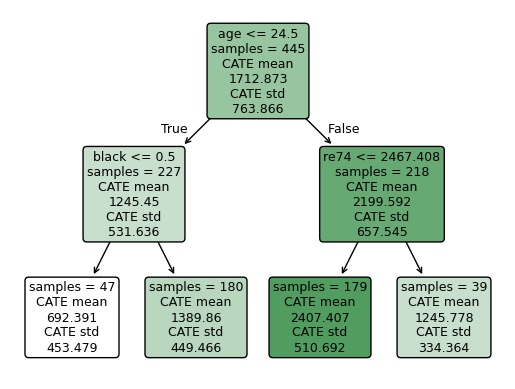

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, X)
intrp.plot(feature_names=X.columns.tolist())
plt.show()

The results show that the treatment in the "National Supported Work Demonstration Job Training Program" has a greater impact on individuals over 24.5 years old with prior income less than or equal to 2467.408, with an average causal treatment effect (CATE) of 2407.407. On the other hand, individuals under 24.5 years old have a lower CATE, particularly those who are not African American, with a value of 1245.45. African Americans in this group show the lowest CATE, 692.391.

These results suggest that the job training program has a greater effect on older adults with lower prior income. In contrast, the impact is less pronounced in younger individuals, especially among non-African Americans, indicating that both age and ethnicity play significant roles in the effectiveness of the treatment.

### 1.4. Heterogeneous effects with causal forests. Use causal forests like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to use the auxiliary variable Y ∗ computed in the previous exercise and fit a random forest regressor. Report the importance of the prediction variables.

In [ ]:
np.random.seed(33)
forest_model = CausalForestDML(max_depth=3)
forest_model = forest_model.fit(Y=df['re78'], X=X, T=df['treat'])

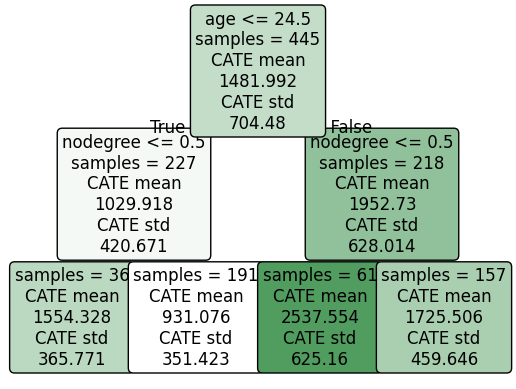

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(forest_model, X)
intrp.plot(feature_names=X.columns.tolist(), fontsize=12)

The results from the causal forest model indicate that age and education level are key factors in determining the effect of the "National Supported Work Demonstration Job Training Program." For individuals under 24.5 years old, those without a high school degree (nodegree ≤ 0.5) have a lower average causal treatment effect (CATE) of 1029.918, with a standard deviation of 420.671. In contrast, those with a high school degree or higher show a higher CATE of 1481.992, with a standard deviation of 704.48.

For individuals over 24.5 years old, the treatment effect varies more significantly. The CATE for those without a high school degree (nodegree ≤ 0.5) is 1952.73, with a standard deviation of 628.014. Among those with higher education levels, the CATE values range from 931.076 (with a standard deviation of 351.423) to 2537.554 (with a standard deviation of 625.16), depending on other factors. These results suggest that the program has a more pronounced effect on older individuals with lower education levels, while the impact is less uniform for those with higher education.

### 1.5. Plot heterogeneous effects. Plot how the predicted treatment effect changes depending on a variable of your choice. (You can see the last example in PD11 for clarification of what you should do in this exercise)

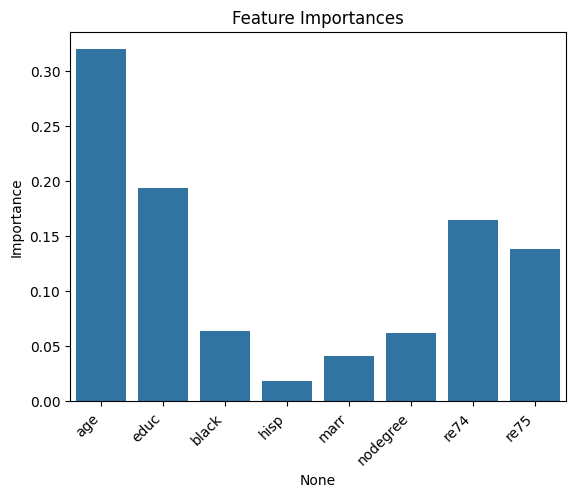

In [ ]:
importances = forest_model.feature_importances()


fig, ax = plt.subplots()
sns.barplot(
    x=X.columns, 
    y=importances, 
    color="C0"
).set(title="Feature Importances", ylabel="Importance")


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()


In [ ]:
df["effect"] = 20*np.exp(-(df['age']-20)**2/80) + 2*(df['marr'] == 1) - 1.5*(df['hisp'] == 1) + (df['black'] == 1) - 1.0
df.loc[df["effect"] < 0, "effect"] = 0 

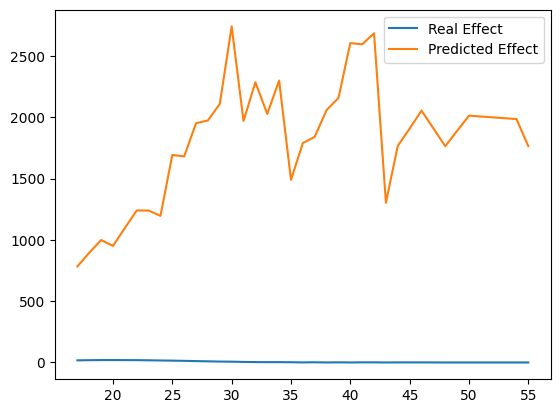

In [ ]:
df["age_bins"] = (df["age"] * 2).astype(int) / 2
effect_bins = df.groupby("age_bins")["effect"].mean()
df["predicted_effect"] = forest_model.effect(X)
predicted_effect_bins = df.groupby("age_bins")["predicted_effect"].mean()


plt.plot(effect_bins.index, effect_bins.values, label="Real Effect")
plt.plot(predicted_effect_bins.index, predicted_effect_bins.values, label="Predicted Effect")
plt.legend()


## Part 2: Double/Debiased machine learning in observational data

In [ ]:
bc = pd.read_csv('biased_control.csv')
bc.head()

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
0,0,45,11,0,0,1,1,21.516670,25.243551,25.564670,2025,91125,121,0,0,236.683369,462.967085,637.236856
1,0,21,14,0,0,0,0,3.175971,5.852565,13.496080,441,9261,196,0,0,44.463593,10.086791,34.252516
2,0,38,12,0,0,1,0,23.039020,25.130760,25.564670,1444,54872,144,0,0,276.468234,530.796421,631.555086
3,0,48,6,0,0,1,1,24.994369,25.243551,25.564670,2304,110592,36,0,0,149.966215,624.718489,637.236856
4,0,18,8,0,0,1,1,1.669295,10.727610,9.860869,324,5832,64,0,0,13.354360,2.786546,115.081624


### 2.2. Group comparisons. For the treatment and control group separately, report summary statistics of three variables of your choice. Can you spot any big differences between the treatment and control groups?

In [ ]:
treatment_group = bc[bc['treat'] == 1]
control_group = bc[bc['treat'] == 0]

variables_of_interest = ['age', 'educ', 're74']

In [ ]:
print("Descriptive statistics for the treatment group:")
print(treatment_group[variables_of_interest].describe())

Descriptive statistics for the treatment group:
              age        educ        re74
count  185.000000  185.000000  185.000000
mean    25.816216   10.345946    2.095574
std      7.155019    2.010650    4.886620
min     17.000000    4.000000    0.000000
25%     20.000000    9.000000    0.000000
50%     25.000000   11.000000    0.000000
75%     29.000000   12.000000    1.291468
max     48.000000   16.000000   35.040070


In [ ]:
print("Descriptive statistics for the control group")
print(control_group[variables_of_interest].describe())

Descriptive statistics for the control group
                age          educ          re74
count  15992.000000  15992.000000  15992.000000
mean      33.225238     12.027514     14.016800
std       11.045216      2.870846      9.569796
min       16.000000      0.000000      0.000000
25%       24.000000     11.000000      4.403452
50%       31.000000     12.000000     15.123580
75%       42.000000     13.000000     23.584180
max       55.000000     18.000000     25.862320


Compared to the control group, the treatment group shows significant differences in the three selected variables. The control group has an average age of 33.23 years, while the treatment group is considerably younger, with an average of 25.82 years. Additionally, the control group has a higher education level, with an average of 12.03 years, compared to 10.35 years in the treatment group. Regarding 1974 income (re74), the control group has an average of 14.02, while the treatment group presents a much lower value of 2.10.

These differences indicate that, on average, the treatment group is younger, less educated, and has lower pre-treatment income than the control group. It's important to consider these disparities when interpreting the treatment effects, as they may influence the results and create biases if not properly adjusted for.

### 2.3. Compute the SMD. Find the simple difference of means, which we can use as a naive estimate of the ATE. How does the result in this case compare to the result in point 1.2.?

In [ ]:
mean_treated = treatment_group['re78'].mean()
mean_control = control_group['re78'].mean()

var_treated = treatment_group['re78'].var()
var_control = control_group['re78'].var()


smd = (mean_treated - mean_control) / np.sqrt((var_treated + var_control) / 2)

print("The Standardized Mean Difference (SMD) for 're78' is:", smd)

The Standardized Mean Difference (SMD) for 're78' is: -0.965352065827647


In [ ]:
ATE = (mean_treated - mean_control)
print("The Average Tratment Effect (ATE) for 're78' is:", ATE)

The Average Tratment Effect (ATE) for 're78' is: -8.49751614813298


The ATE in point 1.2 is 1794.34, while in point 2.3 it is -8.50. This difference indicates that the treatment has a positive effect of 1794.34 on the 're78' value according to the regression in point 1.2. However, when calculating the ATE in point 2.3 using the SMD, the value is negative, implying that the treatment has a much smaller or even near-zero effect in this calculation. The difference in the ATEs could be due to the different methodologies used. The ATE estimated in 1.2 through OLS regression is more specific, while the ATE in 2.3 with the SMD adjusts for the variability of the groups, which may have moderated or distorted the treatment effect.

### 2.4. Using DML. Use the DML procedure as we saw in the Lab, in order to find a better estimate of the ATE. You may use the doubleML packages for Python and R, but this package does not exist for Julia, so you will have to build your own procedure like we saw in class. You will be rewarded extra points for using more than one method for predictions. At the end, report the treatment effect you found, as well as the MSE for D and Y achieved by the method(s) you used.

In [ ]:
X = bc.drop(columns=['treat', 're78'])  
D = bc['treat']
y = bc['re78']

In [ ]:
modely = RandomForestRegressor(n_estimators=100)
modeld = RandomForestRegressor(n_estimators=100)

In [ ]:

def dml(X, D, y, modely, modeld, *, nfolds, classifier=False, time=None, clu=None, cluster=True):
    '''DML for the Partially Linear Model setting with cross-fitting'''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123) 
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    resy = y - yhat
    resD = D - Dhat

    if cluster:
        # final stage ols clustered
        ols_mod = smf.ols(formula='resy ~ 1 + resD', data=pd.concat([clu, pd.Series(time), pd.Series(resy, name='resy'), pd.Series(resD, name='resD')], axis=1)).fit(cov_type='cluster', cov_kwds={"groups": clu})
    else:
        # regular ols
        ols_mod = smf.ols(formula='resy ~ 1 + resD', data=pd.concat([pd.Series(resy, name='resy'), pd.Series(resD, name='resD')], axis=1)).fit()

    point = ols_mod.params[1]
    stderr = ols_mod.bse[1]
    epsilon = ols_mod.resid

    return point, stderr, yhat, Dhat, resy, resD, epsilon


nfolds = 5  
classifier = False 
cluster = False 


point, stderr, yhat, Dhat, resy, resD, epsilon = dml(X, D, y, modely, modeld, nfolds=nfolds, classifier=classifier, cluster=cluster)

In [ ]:
print(f"Estimation of the treatment effect: {point}")
print(f"Standard error: {stderr}")

Estimation of the treatment effect: 1.0045413782490842
Standard error: 0.6668298550688018


In [ ]:
def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point, # point estimate
                         'stderr': stderr, # standard error
                         #'lower': point - 1.96*stderr, # lower end of 95% confidence interval
                         #'upper': point + 1.96*stderr, # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)), # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)) # RMSE of model that predicts treatment D
                         }, index=[name])

In [ ]:
class RLasso(BaseEstimator):
    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.lasso_ = Lasso(alpha=0.1)
        self.lasso_.fit(X, y)
        return self

    def predict(self, X):
        return self.lasso_.predict(X)

In [ ]:
# DML with OLS:
modely_OLS = make_pipeline(StandardScaler(), LinearRegression())
modeld_OLS = make_pipeline(StandardScaler(), LinearRegression())
result_OLS = dml(X, D, y, modely_OLS, modeld_OLS, nfolds=10, classifier=False, cluster=False)
table_OLS = summary(*result_OLS, X, D, y, name='OLS')

# DML with RLasso:
modely_RLasso = make_pipeline(StandardScaler(), RLasso(post=False))
modeld_RLasso = make_pipeline(StandardScaler(), RLasso(post=False))
result_RLasso = dml(X, D, y, modely_RLasso, modeld_RLasso, nfolds=10, classifier=False, cluster=False)
table_RLasso = summary(*result_RLasso, X, D, y, name='Lasso')

# DML with Random Forests:
modely_RF = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
modeld_RF = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
result_RF = dml(X, D, y, modely_RF, modeld_RF, nfolds=10, classifier=False, cluster=False)
table_RF = summary(*result_RF, X, D, y, name='RF')

# DML with Mix (Random Forest + RLasso):
modely_Mix = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123))
modeld_Mix = make_pipeline(StandardScaler(), RLasso(post=False))
result_mix = dml(X, D, y, modely_Mix, modeld_Mix, nfolds=10, classifier=False, cluster=False)
table_mix = summary(*result_mix, X, D, y, name='RF/Lasso Mix')

In [ ]:
table = pd.concat([table_OLS, table_RLasso, table_RF, table_mix], axis=0)
print(table)

              estimate    stderr    rmse y    rmse D
OLS           1.613760  0.556327  6.987603  0.098733
Lasso         0.624034  0.517576  6.999882  0.106335
RF            0.884484  0.666483  7.150211  0.084350
RF/Lasso Mix  0.588423  0.528694  7.150211  0.106335
